In [1]:
#import necessary library
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Because in almost all the dataset there isn't a date but a value that represents the offset in days form a zero date (21/01/2020), it is used a constant to define the zero date.

In [2]:
#constant declaration for the 0 date
DATE_ZERO = datetime.date(2020, 1, 21)

Load the necessary dataframes.
Total deaths and total cases are retrieved from the full dataset on Internet while total deaths and total cases per million, are retrieved locally, by other datasets.

In [3]:
#load full dataset from internet
df_all_data_ = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")
#load local dataset for total cases and total deaths per million of inhabitants
df_total_deaths_x_million_ = pd.read_csv("../world_analysis/dataset/total-covid-deaths-per-million.csv")
df_total_cases_x_million_ = pd.read_csv("../world_analysis/dataset/total-confirmed-cases-of-covid-19-per-million-people.csv")

Clean the full dataset renaming columns with more meaningful name/format and splitting in different sub-dataframe

In [4]:
df_all_data = df_all_data_.copy()
df_all_data.rename(columns={"location": "Country","date":"Date", "new_cases":"New cases",
                            "new_deaths":"New deaths","total_cases":"Total cases", 
                            "total_deaths":"Total deaths"}, inplace = True)
df_total_deaths_ = df_all_data.copy().drop(['New cases','New deaths','Total cases'],axis = 1)
df_new_deaths_ = df_all_data.copy().drop(['New cases','Total deaths','Total cases'],axis = 1)
df_total_cases_ = df_all_data.copy().drop(['New cases','New deaths','Total deaths'],axis = 1)
df_new_cases_ = df_all_data.copy().drop(['New deaths','Total deaths','Total cases'],axis = 1)


View the 4 new created datasets

In [5]:
df_total_deaths_.head()

,Date,Country,Total deaths
0,2019-12-31,Afghanistan,0
1,2020-01-01,Afghanistan,0
2,2020-01-02,Afghanistan,0
3,2020-01-03,Afghanistan,0
4,2020-01-04,Afghanistan,0


In [6]:
df_new_deaths_.head()

,Date,Country,New deaths
0,2019-12-31,Afghanistan,0
1,2020-01-01,Afghanistan,0
2,2020-01-02,Afghanistan,0
3,2020-01-03,Afghanistan,0
4,2020-01-04,Afghanistan,0


In [7]:
df_total_cases_.head()

,Date,Country,Total cases
0,2019-12-31,Afghanistan,0
1,2020-01-01,Afghanistan,0
2,2020-01-02,Afghanistan,0
3,2020-01-03,Afghanistan,0
4,2020-01-04,Afghanistan,0


In [8]:
df_new_cases_.head()

,Date,Country,New cases
0,2019-12-31,Afghanistan,0
1,2020-01-01,Afghanistan,0
2,2020-01-02,Afghanistan,0
3,2020-01-03,Afghanistan,0
4,2020-01-04,Afghanistan,0


Define a function to perform the following operations on local dataset:
* add a column to store the date of reference for each row;
* drop the column with the offset day, and the country code;
* rename column "Entity" with more meaningful name "Country"

In [9]:
def cleanDataSet(dataframe_to_clean):
    #Create new column for the date evaluating the date of reference
    dataframe_to_clean['Date'] = dataframe_to_clean['Year'].apply(lambda x: datetime.timedelta(days=x) + DATE_ZERO)
    #set the date as index of the dataframe
    dataframe_to_clean.set_index('Date', inplace = True)
    dataframe_to_clean.drop(['Year','Code'], axis = 1, inplace = True)
    dataframe_to_clean.rename(columns={"Entity": "Country"}, inplace = True)
    return dataframe_to_clean

Define a function that allow to plot data of a list of countries starting from the first confirmed case 

In [10]:
def plotGrowthDataFromFirstCase(dataset, countriesList, columnReference,
                               graphTitle):
    """This procedure allow to plot data relative to the growth of
        a specific value starting from the first case.
        Parameters:
        dataset -> is the dataset where the data are retreived
        countriesList -> is the list of countries which data must be plotted
        columnReference -> is the name of the column under analysis
        graphTitle -> is the name of the graph that must be showed
    """
    for country in countriesList:
        country_growth_total_cases = dataset[dataset['Country'] == country]
        country_growth_total_cases = country_growth_total_cases[country_growth_total_cases[columnReference] > 0]
        plt.plot(range(len(country_growth_total_cases)),country_growth_total_cases[columnReference], label = country)
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title(graphTitle)
    plt.show()
    

Define a function that create a new dataframe containing the growth rate for each country. It is possible to specify the time interval to consider, expressend in days.

In [11]:
def evaluateGrowthRate(dataset, number_of_days, reference_column):
    """This function allows to evaluate the growth rate of the reference
       column in input, gathering the data from the dataset in input with
       a specific delay expressed in days. The starting and ending date
       considered is based by the minumum and maximum date present in the
       input dataset. The dataframe in input must have a column 'Date'
       containing the list of reference date. The value returned is a
       new dataframe containing for each country a specific column and the
       value in each row is the percentage growth calculated from the previous 
       date.
       Parameters:
       dataset -> is the dataset to gather the data
       number_of_days -> is the frequency in which the evaluation is done
       reference_column -> is the column in the dataset in input to consider
           for evaluating the growth
    """
    #get the minimum date to consider
    minimum_date = dataset['Date'].min()
    #get the maximum date to consider
    maximum_date = dataset['Date'].max()
    #create the list of country to consider
    list_of_country = dataset['Country'].unique()
    #Create a new dataframe with the list of country in each column
    #and the list of date as index
    date_list = pd.date_range(start = minimum_date, end = maximum_date, 
                              freq = str(number_of_days) + 'D')
    #create a new dataframe with country as columns and date as index
    #filled with 0 values
    zero_data = np.zeros(shape=(len(date_list),len(list_of_country)))
    df_growth = pd.DataFrame(zero_data, index = date_list, columns = list_of_country)
    #iterate on all the index date
    for index_date in range(len(date_list)):
        #first row is not considered because there is not a previus value
        #for which the growth can be evaluated
        if index_date == 0:
            continue
        else:
            #get the string date that has to be evaluated
            current_date = str(date_list.values[index_date])[:10]
            #get the previous date
            previous_date = str(date_list.values[index_date - 1])[:10]
            #iterate on all the countries present in the input dataset
            for country in list_of_country:
                #get the list of value available for the country in exam
                country_values = dataset.loc[dataset['Country'] == country]
                #get the row value for the date/country in exame
                current_value = country_values.loc[dataset['Date'] == current_date]
                #get the previous row value for the date/country in exame
                previous_value = country_values.loc[dataset['Date'] == previous_date]
                #verify that the two values are not empty, otherwise skip to the next
                #iteration
                if len(current_value) > 0 and len(previous_value) > 0:
                    #if values are not empty, extract the two number used to evaluate
                    #the growth
                    current_value = current_value[reference_column].values[0]
                    previous_value = previous_value[reference_column].values[0]
                    #verifies that the previous value is not 0 to avoid division error
                    if previous_value > 0:
                        #evaluate the percentage growth between the 2 consecutive values
                        growth_value = (current_value - previous_value) / previous_value * 100
                        #set the evaluated value in the dataframe, at the right location
                        df_growth.loc[current_date,country] = growth_value
    #return the new dataframe with the outcomes
    return df_growth

Print data of the top 10 countries for number of deaths and plot the growth starting from the first confirmed death.

World number of deaths: 18565
          Country        Date  Total deaths
0           Italy  2020-03-25          6820
1           China  2020-03-25          3287
2           Spain  2020-03-25          2696
3            Iran  2020-03-25          1934
4          France  2020-03-25          1100
5   United States  2020-03-25           801
6  United Kingdom  2020-03-25           422
7     Netherlands  2020-03-25           276
8         Germany  2020-03-25           149
9     South Korea  2020-03-25           126


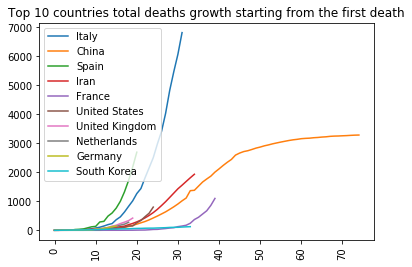

In [12]:
#create a copy of the dataset
df_total_deaths = df_total_deaths_.copy()

#get the maximum value of each country and sort the data in descendent way
df_group_total_deaths = df_total_deaths.groupby('Country').max()
df_group_total_deaths.sort_values(by = 'Total deaths',ascending = False, inplace = True)
#print data of all the world deaths
print("World number of deaths:", df_group_total_deaths.iloc[0]['Total deaths'])
#loc the first 10 rows (it starts form the row 1 and not row 0 because
#the first row contains data of all the world)
top_10_total_deaths = df_group_total_deaths.iloc[1:11]
top_10_total_deaths.reset_index(inplace = True)
#print the data
print(top_10_total_deaths)
#plot the graph
plotGrowthDataFromFirstCase(df_total_deaths, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth starting from the first death')

Print data of the top 10 countries for number of cases and plot the growth starting from the first confirmed case.

World number of cases: 416916
          Country        Date  Total cases
0           China  2020-03-25        81847
1           Italy  2020-03-25        69176
2   United States  2020-03-25        55231
3           Spain  2020-03-25        39673
4         Germany  2020-03-25        31554
5            Iran  2020-03-25        24811
6          France  2020-03-25        22302
7     South Korea  2020-03-25         9137
8     Switzerland  2020-03-25         8789
9  United Kingdom  2020-03-25         8077


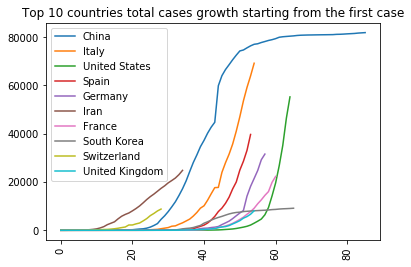

In [13]:
#create a copy of the dataset
df_total_cases = df_total_cases_.copy()

#get the maximum value of each country and sort the data in descendent way
df_group_total_cases = df_total_cases.groupby('Country').max()
df_group_total_cases.sort_values(by = 'Total cases',ascending = False, inplace = True)
#print data of all the world deaths
print("World number of cases:", df_group_total_cases.iloc[0]['Total cases'])
#loc the first 10 rows (it starts form the row 1 and not row 0 because
#the first row contains data of all the world)
top_10_total_cases = df_group_total_cases.iloc[1:11]
top_10_total_cases.reset_index(inplace = True)
#print the data
print(top_10_total_cases)
#plot the graph
plotGrowthDataFromFirstCase(df_total_cases, top_10_total_cases['Country'],'Total cases',
                            'Top 10 countries total cases growth starting from the first case')

Print data of the top 10 countries for number of deaths per million and plot the growth starting from the first confirmed death.

World number of deaths: 589.3099180859214
          Country  \
0           Italy   
1           Spain   
2            Iran   
3  Cayman Islands   
4          France   
5      Luxembourg   
6     Netherlands   
7     Switzerland   
8         Belgium   
9            Guam   

   Total confirmed deaths due to COVID-19 per million people (deaths per million)  
0                                         100.509697                               
1                                          46.669022                               
2                                          21.573238                               
3                                          15.216068                               
4                                          13.175329                               
5                                          12.780043                               
6                                          12.430790                               
7                                           7.625986  

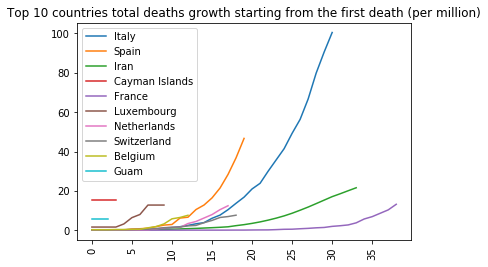

In [14]:
#create a copy of the dataset
df_total_deaths_x_million = df_total_deaths_x_million_.copy()

#clean the datasets
df_total_deaths_x_million = cleanDataSet(df_total_deaths_x_million)

#get the maximum value of each country and sort the data in descendent way
df_group_total_deaths_x_million = df_total_deaths_x_million.groupby('Country').max()
df_group_total_deaths_x_million.sort_values(by = 'Total confirmed deaths due to COVID-19 per million people (deaths per million)',ascending = False, inplace = True)
#print data of all the world deaths
print("World number of deaths:", df_group_total_deaths_x_million.iloc[0]['Total confirmed deaths due to COVID-19 per million people (deaths per million)'])
#loc the first 10 rows (it starts form the row 1 and not row 0 because
#the first row contains data of all the world)
top_10_total_deaths_x_million = df_group_total_deaths_x_million.iloc[1:11]
top_10_total_deaths_x_million.reset_index(inplace = True)
#print the data
print(top_10_total_deaths_x_million)
#plot the graph
plotGrowthDataFromFirstCase(df_total_deaths_x_million, top_10_total_deaths_x_million['Country'], 
                            'Total confirmed deaths due to COVID-19 per million people (deaths per million)',
                            'Top 10 countries total deaths growth starting from the first death (per million)')

Print data of the top 10 countries for number of cases per million and plot the growth starting from the first confirmed case.

World number of cases: 4449.289881548706
          Country  \
0  Faeroe Islands   
1         Iceland   
2         Andorra   
3      Luxembourg   
4         Vatican   
5   Liechtenstein   
6           Italy   
7     Switzerland   
8           Spain   
9          Monaco   

   Total confirmed cases of COVID-19 per million people (cases per million)  
0                                        2353.422695                         
1                                        1664.468864                         
2                                        1462.499191                         
3                                        1274.809258                         
4                                        1236.093943                         
5                                        1206.177728                         
6                                         978.104731                         
7                                         805.465937                         
8                        

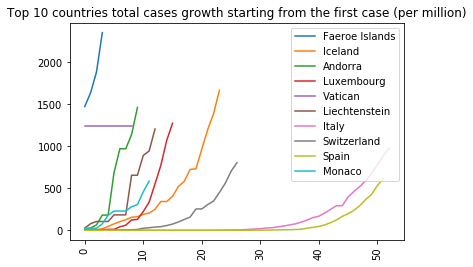

In [15]:
#create a copy of the dataset
df_total_cases_x_million = df_total_cases_x_million_.copy()

#clean the datasets
df_total_cases_x_million = cleanDataSet(df_total_cases_x_million)

#get the maximum value of each country and sort the data in descendent way
df_group_total_cases_x_million = df_total_cases_x_million.groupby('Country').max()
df_group_total_cases_x_million.sort_values(by = 'Total confirmed cases of COVID-19 per million people (cases per million)',ascending = False, inplace = True)
#print data of all the world deaths
print("World number of cases:", df_group_total_cases_x_million.iloc[0]['Total confirmed cases of COVID-19 per million people (cases per million)'])
#loc the first 10 rows (it starts form the row 1 and not row 0 because
#the first row contains data of all the world)
top_10_total_cases_x_million = df_group_total_cases_x_million.iloc[1:11]
top_10_total_cases_x_million.reset_index(inplace = True)
#print the data
print(top_10_total_cases_x_million)
#plot the graph
plotGrowthDataFromFirstCase(df_total_cases_x_million, top_10_total_cases_x_million['Country'], 
                            'Total confirmed cases of COVID-19 per million people (cases per million)',
                            'Top 10 countries total cases growth starting from the first case (per million)')

Print data of the top ten day/country for new deaths

In [16]:
#copy the dataframe
df_new_deaths = df_new_deaths_.copy()
#delete the row regarding the entire world
df_new_deaths = df_new_deaths[df_new_deaths['Country'] != 'World']
#sort the data in descending order and print the top 10 rows
df_new_deaths.sort_values(by = 'New deaths', ascending = False, inplace = True)
df_new_deaths.head(10)

,Date,Country,New deaths
3332,2020-03-22,Italy,795
3335,2020-03-25,Italy,743
3333,2020-03-23,Italy,649
3331,2020-03-21,Italy,625
3334,2020-03-24,Italy,601
5818,2020-03-25,Spain,514
3329,2020-03-19,Italy,473
5817,2020-03-24,Spain,462
3330,2020-03-20,Italy,429
5816,2020-03-23,Spain,394


Print data of the top ten day/country for new cases

In [17]:
#copy the dataframe
df_new_cases = df_new_cases_.copy()
#delete the row regarding the entire world
df_new_cases = df_new_cases[df_new_cases['Country'] != 'World']
df_new_cases.sort_values(by = 'New cases', ascending = False, inplace = True)
df_new_cases.head(10)

,Date,Country,New cases
1269,2020-02-13,China,15141
6597,2020-03-24,United States,11236
6598,2020-03-25,United States,8789
6596,2020-03-23,United States,8459
6595,2020-03-22,United States,7123
5818,2020-03-25,Spain,6584
3332,2020-03-22,Italy,6557
3326,2020-03-16,Italy,6230
3331,2020-03-21,Italy,5986
2393,2020-03-20,Germany,5940


Print the weekly growth rate of the total number of deaths for some countries

In [18]:
df_total_deaths = df_total_deaths_.copy()
death_growth_rate = evaluateGrowthRate(df_total_deaths, 7, 'Total deaths')
some_countries_deaths_growth = death_growth_rate[['Italy', 'Spain', 'United States','China','Singapore']]
some_countries_deaths_growth

,Italy,Spain,United States,China,Singapore
2019-12-31,0.000000,0.000000,0.000000,0.000000,0.0
2020-01-07,0.000000,0.000000,0.000000,0.000000,0.0
2020-01-14,0.000000,0.000000,0.000000,0.000000,0.0
2020-01-21,0.000000,0.000000,0.000000,500.000000,0.0
2020-01-28,0.000000,0.000000,0.000000,1666.666667,0.0
2020-02-04,0.000000,0.000000,0.000000,301.886792,0.0
2020-02-11,0.000000,0.000000,0.000000,138.732394,0.0
2020-02-18,0.000000,0.000000,0.000000,83.775811,0.0
2020-02-25,0.000000,0.000000,0.000000,42.589620,0.0
2020-03-03,766.666667,0.000000,0.000000,10.544090,0.0


Print the 3 days growth rate of the total number of cases for some countries

In [21]:
df_total_cases = df_total_cases_.copy()
case_growth_rate = evaluateGrowthRate(df_total_cases, 3, 'Total cases')
some_countries_cases_growth = case_growth_rate[['Italy', 'Spain', 'United States','China','Singapore','Thailand']]
some_countries_cases_growth


,Italy,Spain,United States,China,Singapore,Thailand
2019-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.000000,0.000000,0.000000,62.962963,0.000000,0.000000
2020-01-06,0.000000,0.000000,0.000000,34.090909,0.000000,0.000000
2020-01-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-18,0.000000,0.000000,0.000000,35.593220,0.000000,100.000000
2020-01-21,0.000000,0.000000,0.000000,382.500000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,128.497409,0.000000,100.000000
2020-01-27,0.000000,0.000000,400.000000,214.625850,33.333333,100.000000
